# 1. Camera Calibration with DLT

## Code explanation
Direct linear transformation (DLT) is an algorithm which solves a set of variables from a set of similarity relations: for. where and are known vectors, denotes equality up to an unknown scalar multiplication, and. is a matrix (or linear transformation) which contains the unknowns to be solved.
* Selected 12 points in real-world coordinates, and their corresponding image coordinates.
* Using DLT algorithm found the camera matrix P.
* Found the intrinsic parameters (K), and the extrinsic parameters (R,t), by QR factorization of P.
* Reprojected the real-world points on the image, and found reprojection error.

## Challenges
* Selecting image points and the corresponding real points, and their count, in order to minimize projection error.

In [56]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

np.random.seed(0)

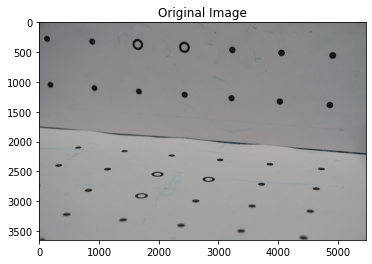

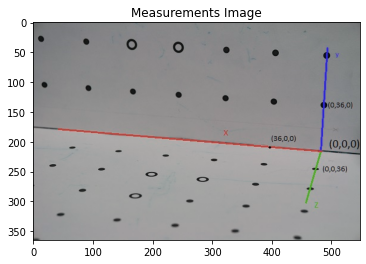

In [96]:
plt.figure()
org_img = cv2.imread('../data/black-dots.JPG')
plt.title('Original Image')
plt.imshow(org_img)
plt.figure()
msr_img = cv2.imread('../data/measurements.jpg')
plt.title('Measurements Image')
plt.imshow(msr_img)

In [58]:
UNIT = 36

world_coords = np.array([[0, 1, 0],
                        [0, 2, 0],
                        [1, 1, 0],
                        [1, 2, 0],
                        [0, 0, 1],
                        [1, 0, 1],
                        [0, 0, 2],
                        [1, 0, 2],
                        [0, 0, 3],
                        [1, 0, 3],
                        [0, 0, 4],
                        [1, 0, 4]]).astype('float64')

world_coords = world_coords*UNIT

In [97]:
def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        image_points.append([x,y])

In [59]:
image_points = []

read=False
if read==True:
    # reading the image
    img = cv2.imread('../data/black-dots.JPG', 1)

    # plt.figure()
    # plt.imshow(img)
    # plt.show()

    # displaying the image
    w = 720
    h0,w0 = img.shape[0],img.shape[1]
    h = w*img.shape[0]//img.shape[1]
    img = cv2.resize(img, (w,h))
    # img = cv2.resize(img, (100,100))
    cv2.imshow('image', img)

    # setting mouse handler for the image
    # and calling the click_event() function

    while(True):
        cv2.setMouseCallback('image', click_event)
        k = cv2.waitKey(33)
        if cv2.getWindowProperty('image', cv2.WND_PROP_VISIBLE)<1:
        # cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()
    image_points = np.array(image_points).astype('float64')
    image_points[:,0] = image_points[:,0]*h0/h
    image_points[:,1] = image_points[:,1]*w0/w

else:
    image_points = np.array([[4871.6, 1406. ],
                            [4932.4 , 585.2],
                            [4043.2 ,1352.8],
                            [4058.4 , 539.6],
                            [4734.8 ,2462.4],
                            [3860.8 ,2394. ],
                            [4643.6 ,2812. ],
                            [3724.  ,2728.4],
                            [4544.8 ,3184.4],
                            [3564.4 ,3093.2],
                            [4438.4 ,3625.2],
                            [3382.  ,3518.8]]).astype('float64')
    

[[4871.6 1406. ]
 [4932.4  585.2]
 [4043.2 1352.8]
 [4058.4  539.6]
 [4734.8 2462.4]
 [3860.8 2394. ]
 [4643.6 2812. ]
 [3724.  2728.4]
 [4544.8 3184.4]
 [3564.4 3093.2]
 [4438.4 3625.2]
 [3382.  3518.8]]


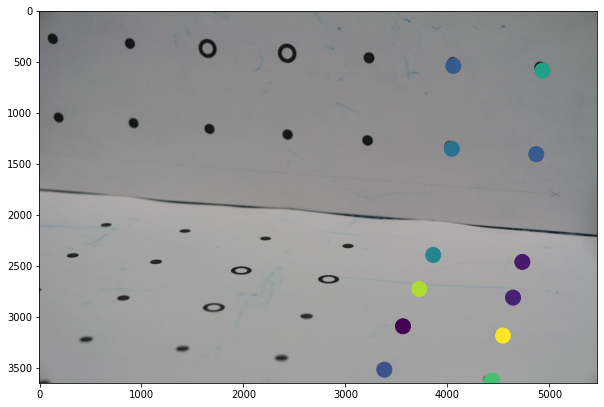

In [60]:
plt.figure(figsize=(10,15))
img=cv2.imread('../data/black-dots.JPG')
imgplot = plt.imshow(img)
N = len(image_points)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

print (image_points)
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [61]:
def homo_coords(x,X):
    ones = np.ones((x.shape[0],1))
    x = np.concatenate((x,ones),axis = 1)
    X = np.concatenate((X,ones),axis = 1)
    return x, X

def DLT(x,X):
    """
    input x: the image points
    X: world points
    return Projection matrix (3x4)
    """  
    i = 0
    N=len(x)
    M = np.array([-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]])
    M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
    
    for i in range(1,len(x)):
        M = np.vstack((M, [-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]]))
        M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
    u, d, vt = np.linalg.svd(M)  
    # The last column of vt is the eigenvector corresponding to the last eigenvalue.
    P = vt[-1].reshape(3,4)
    P /= P[-1,-1]

    M=[]
    for i in range(N):
        Xi=[-X[i,0], -X[i,1], -X[i,2], -1.0, 0.0, 0.0, 0.0, 0.0, x[i,0]*X[i,0], x[i,0]*X[i,1], x[i,0]*X[i,2], x[i,0]]
        M.append(Xi)
        xi=[0.0, 0.0, 0.0, 0.0, -X[i,0], -X[i,1], -1*X[i,2], -1.0, x[i,1]*X[i,0], x[i,1]*X[i,1], x[i,1]*X[i,2], x[i,1]]
        M.append(xi)
    M = np.array(M)

    Rt, K_inv = np.linalg.qr(np.linalg.inv(P[:3,:3]))
    R = Rt.T
    K = np.linalg.inv(K_inv)
    t = -np.linalg.inv(P[:3,:3]) @ P[:,3]
    
    K /= K[2,2]
    
    return P, M, K, R, t

x,X = homo_coords(image_points,world_coords)
N = len(x)

P, M, K, R, t = DLT(x,X)
print('P is :\n',P)
print('M is :\n',M)
print('K is :\n',K)
print('R is :\n',R)
print('t is :\n',t)

P is :
 [[-2.12569943e+01 -2.47021401e+00 -9.74849446e+00  4.81081735e+03]
 [-9.93763993e-01 -2.25254597e+01  4.26740246e+00  2.17235555e+03]
 [ 3.57354270e-04 -8.49812408e-04 -1.60646659e-03  1.00000000e+00]]
M is :
 [[-0.000000e+00 -3.600000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.753776e+05
   0.000000e+00  4.871600e+03]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00
  -3.600000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00  5.061600e+04
   0.000000e+00  1.406000e+03]
 [-0.000000e+00 -7.200000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.551328e+05
   0.000000e+00  4.932400e+03]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00
  -7.200000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00  4.213440e+04
   0.000000e+00  5.852000e+02]
 [-3.600000e+01 -3.600000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.00000

In [62]:
def get_points(P,X,norm = False,T_ = None):
    points = np.dot(P,X.T)
    if(norm==True):
        points = np.dot(np.linalg.inv(T_),points)
    points /= points[2]
    points_T = points.T[:,0:2]
    points = points_T
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    points,_ = homo_coords(points,x)
    err = np.sqrt(np.mean((points - x) ** 2))
    return err
err = get_err(x,X,P)
print("rmse ",err)

rmse  3.928115393169983


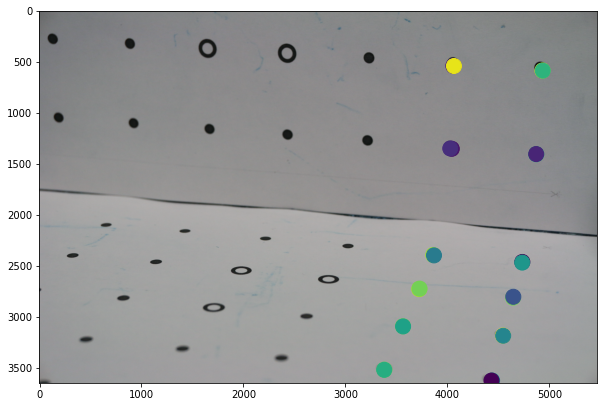

In [63]:
def reproject(P,X,x,path='../data/black-dots.JPG',norm=False,T_=None):  
    
    re_proj = get_points(P, X, norm, T_)
    re_proj = np.array(re_proj).astype('float64') 

    finalX = np.hstack((x[:,0], re_proj[:,0]))
    finalY = np.hstack((x[:,1], re_proj[:,1]))

    N = len(finalX)    

    img=cv2.imread(path)
    plt.figure(figsize=(10,15))
    plt.imshow(img)

    colors = np.random.rand(N)
    area = (15 * np.ones(N))**2 
    
    plt.scatter(finalX[:], finalY[:], c=colors, s=area)
    plt.show()
    
    # # Calculate mse error in reprojection
    # diff=x[:,:2]-re_proj
    # rmse=np.linalg.norm(diff,axis=1)
    # mse=np.sqrt(np.mean(rmse*rmse))
    # print('MSE in reprojection is :\n',mse)

reproject(P,X,x)

# 2: Camera Calibration with Ransac

## Code explanation
Random sample consensus, or RANSAC, is an iterative method for estimating a mathematical model from a data set that contains outliers. The RANSAC algorithm works by identifying the outliers in a data set and estimating the desired model using data that does not contain outliers.
* Selecting a batch size of 6 random points out of N (N=12). Performing DLT on those set of points.
* The camera projection matrix is then computed using DLT with these 6 points. The image coordinates of the remaining known points are predicted using their world coordinates and the
projection matrix.
* Saving the best values obatained out of all the models, by comparing thier error values.

## Challenges
* Experimenting with values of n_iter, to try and obtain minimum projection error.

In [64]:
def ransac_estimation(image_points, world_coords):
    n_iter = 500
    batch_size = N
    best_values = {}
    least_rmse = 1e10
    for i in range(n_iter):
        mini_batch = np.random.choice(batch_size, 6)
        
        img_coord = image_points[mini_batch]
        real_coord = world_coords[mini_batch]
        img_coord,real_coord = homo_coords(img_coord,real_coord)
        try:
            P,M,K,R,t = DLT(img_coord,real_coord)
        except:
            continue
        rmse = get_err(x,X,P)
        # print(rmse)
        if rmse < least_rmse:
            least_rmse = rmse
            best_values['P'] = P
            best_values['M'] = M
            best_values['K'] = K
            best_values['R'] = R
            best_values['t'] = t
            best_values['rmse'] = rmse
    return best_values

best_values = ransac_estimation(image_points, world_coords)
for key, value in best_values.items():
    print(f"{key} : {value}")

P : [[-2.15294057e+01 -2.50361642e+00 -9.54462632e+00  4.81262474e+03]
 [-1.03018663e+00 -2.25767566e+01  4.39313655e+00  2.17541183e+03]
 [ 3.17837621e-04 -8.46390627e-04 -1.55472212e-03  1.00000000e+00]]
M : [[-3.600000e+01 -7.200000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  1.461024e+05  2.922048e+05
   0.000000e+00  4.058400e+03]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -3.600000e+01
  -7.200000e+01 -0.000000e+00 -1.000000e+00  1.942560e+04  3.885120e+04
   0.000000e+00  5.396000e+02]
 [-0.000000e+00 -7.200000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.551328e+05
   0.000000e+00  4.932400e+03]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00
  -7.200000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00  4.213440e+04
   0.000000e+00  5.852000e+02]
 [-0.000000e+00 -3.600000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0

/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: divide by zero encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: invalid value encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/1845656440.py:2: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T


## DLT vs RANSAC comparison

```Error (DLT) = 3.93```<br>
```Error (RANSAC) = 4.61```<br>
We observe that DLT has less rmse (projection error) than RANSAC, therefore, it is better.

# 3: Create a wireframe using Calibration Matrix (Ransac)

## Code Explanation
* Once we have the prediction matrix (using RANSAC), we can use this matrix to predict the image coordinates for points using their known world coordinates.
* We then construct a wireframe using these predicted image coordinates and then join them together using lines.

## Challenges
* Understanidng which points needed to be connected based on the distance between them.

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb
# from zhang import zhang_calibration, predict_points_zhang


def predict_points(projection_matrix, world_points):
    """Use the projection matrix to predict image_points"""
    points = []
    for (x, y, z) in world_points:
        A = np.array([[x], [y], [z], [1]])
        i_pred = np.dot(projection_matrix, A)
        i_pred = i_pred.reshape(1, -1)[0]
        i_pred = i_pred[:-1] / i_pred[-1]
        points.append(i_pred)

    points = np.array(points, dtype=np.int)
    return points


def plot_wireframe(image, points):
    img = image.copy()
    for (x, y) in points:
        img = cv2.circle(img, (int(x), int(y)), 50, (255, 0, 0), -1)

    for p in points:
        distance = np.sum((points - p)**2, axis=1)
        min_index = np.argsort(distance)[1:5]
        for nearest_point in points[min_index]:
            img = cv2.line(img, tuple(p), tuple(nearest_point), (255, 0, 0), 10)
    return img


def plot_points(image, points):
    img = image.copy()
    for (x, y) in points:
        if x < 0 or x >= img.shape[0] or y < 0 or y >= img.shape[1]:
            continue
        img = cv2.circle(img, (x, y), 50, (255, 0, 0), -1)
    return img

/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: divide by zero encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: invalid value encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/1845656440.py:2: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T
/tmp/ipykernel_8698/1561311264.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  points = np.array(points, dtype=np.int)


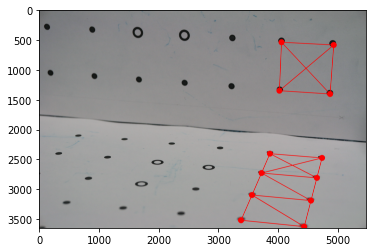

In [66]:
image = cv2.imread('../data/black-dots.JPG')

best_values = ransac_estimation(image_points, world_coords)
projection_matrix = best_values['P']
pred_points = predict_points(projection_matrix, world_coords)
img = plot_wireframe(image, pred_points[0:4])
# plt.imshow(img)
# plt.show()
img = plot_wireframe(img, pred_points[4:12])
plt.imshow(img)
plt.show()

# folder = "../data/"
# image_names = ["IMG_5456.JPG", "IMG_5457.JPG", "IMG_5458.JPG", "IMG_5459.JPG", "IMG_5460.JPG",
#                 "IMG_5461.JPG", "IMG_5462.JPG", "IMG_5463.JPG", "IMG_5464.JPG", "IMG_5465.JPG",
#                 "IMG_5466.JPG", "IMG_5467.JPG", "IMG_5468.JPG", "IMG_5469.JPG", "IMG_5470.JPG"]
# images = [cv2.imread(os.path.join(folder, x)) for x in image_names]

# ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints = zhang_calibration(images, size=(8, 6))
# pred_points = predict_points_zhang(rvecs[-1], tvecs[-1], mtx, dist, objpoints[-1])[0].reshape(48, 2)
# img = plot_wireframe(images[-1], pred_points)

# plt.imshow(img)
# plt.show()

## Observations

The constructed wireframe is aligned with real-world coordinates of the black dots.

# 4: Radial Distortion

## Observations
As we see below, the undistorted image has much less projection error as compared to the original distorted image (error is obtained using DLT).<br>
```Error (original distorted image) = 3.93```<br>
```Error (undistorted image) = 0.24```

Distortion Coefficients : 
 [[ 4.44507075e+00 -5.49693415e+01 -1.69587554e-02 -2.58323855e-01
   2.87220343e+02]] 



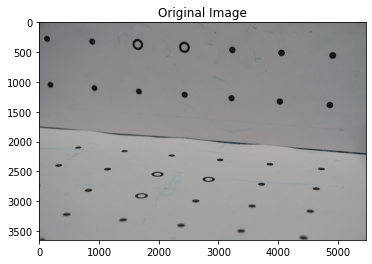

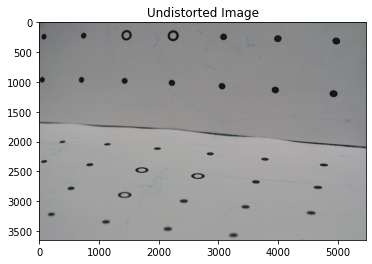

In [67]:
image = cv2.imread('../data/black-dots.JPG')

x,X = homo_coords(image_points, world_coords)
P,M,K,R,t = DLT(x, X)

k1 = K
k1[0,1] = 0
k1[0,0] = abs(k1[0][0])
k1[1,1] = abs(k1[1][1])
world_points_m = np.array([world_coords]).astype(np.float32)
img_pts_m = np.array([image_points]).astype(np.float32)
# img_pts_m = np.array([[pt for [pt] in image_points]]).astype(np.float32)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_points_m,img_pts_m,(image.shape[1],image.shape[0]),k1,None,None,flags=(cv2.CALIB_USE_INTRINSIC_GUESS))
h,w = image.shape[:2]
newK,roi = cv2.getOptimalNewCameraMatrix(k1,dist,(w,h),0,(w,h))
print("Distortion Coefficients : \n", dist, "\n")
undi_img = cv2.undistort(image,mtx,dist,None,newK)
plt.figure()
plt.title('Original Image')
plt.imshow(image)
plt.show()

plt.figure()
plt.title('Undistorted Image')
plt.imshow(undi_img)
plt.show()

In [68]:
undis_image_points = []

def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        undis_image_points.append([x,y])

read=False
if read==True:
    # reading the image
    img = cv2.imread('../images/undistorted.png', 1)

    # plt.figure()
    # plt.imshow(img)
    # plt.show()

    # displaying the image
    w = 720
    h0,w0 = img.shape[0],img.shape[1]
    h = w*img.shape[0]//img.shape[1]
    img = cv2.resize(img, (w,h))
    # img = cv2.resize(img, (100,100))
    cv2.imshow('image', img)

    # setting mouse handler for the image
    # and calling the click_event() function

    while(True):
        cv2.setMouseCallback('image', click_event)
        k = cv2.waitKey(33)
        if cv2.getWindowProperty('image', cv2.WND_PROP_VISIBLE)<1:
        # cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()
    undis_image_points = np.array(undis_image_points).astype('float64')
    undis_image_points[:,0] = undis_image_points[:,0]*h0/h
    undis_image_points[:,1] = undis_image_points[:,1]*w0/w

else:
    undis_image_points = np.array([[334.4    ,     94.55   ],
                                [337.50588235,  42.88333333],
                                [276.42352941,  91.96666667],
                                [279.01176471,  39.78333333],
                                [324.04705882, 165.85      ],
                                [265.03529412, 160.16666667],
                                [318.35294118, 188.06666667],
                                [256.23529412, 182.38333333],
                                [311.62352941, 213.38333333],
                                [245.88235294, 207.18333333]]).astype('float64')

In [69]:
x,X = homo_coords(undis_image_points,world_coords[0:10])
N = len(x)

P, M, K, R, t = DLT(x,X)
err = get_err(x,X,P)
print("rmse:\t",err)

print(undis_image_points)

rmse:	 0.23522676344010962
[[334.4         94.55      ]
 [337.50588235  42.88333333]
 [276.42352941  91.96666667]
 [279.01176471  39.78333333]
 [324.04705882 165.85      ]
 [265.03529412 160.16666667]
 [318.35294118 188.06666667]
 [256.23529412 182.38333333]
 [311.62352941 213.38333333]
 [245.88235294 207.18333333]]


# Problem 5: Zhang's Algorithm

## Code Explanation
Zhang model is a camera calibration method that uses traditional calibration techniques (known calibration points) and self-calibration techniques (correspondence between the calibration points when they are in different positions). It uses a known pattern such as a checkerboard is
used to estimate the calibration matrix.
* We obtain the world-coordinates of the checkerboard, by one of it's conrners as origin.
* Using cv2.findChessboardCorners(), we can obtain the image coordinates.
* Using these, we can compute the projection matrix.
* We obtain the coordinates using multiple images to improve our model's accuracy.

## Challenges
* Checking for various grid sizes of images, are the corners being detected or not.
* Identifying errors due to incorrect format of objectPoints in cv2.calibrateCamera()

In [70]:
folder = "../data/"
image_names = ["checkerboard-01.JPG", "checkerboard-02.JPG", "checkerboard-03.JPG", "checkerboard-04.JPG", "checkerboard-05.JPG",
                "checkerboard-06.JPG", "checkerboard-07.JPG", "checkerboard-08.JPG", "checkerboard-09.JPG", "checkerboard-10.JPG",
                "checkerboard-11.JPG", "checkerboard-12.JPG", "checkerboard-13.JPG", "checkerboard-14.JPG", "checkerboard-15.JPG"]
zhang_img_list = [cv2.imread(os.path.join(folder, x)) for x in image_names]

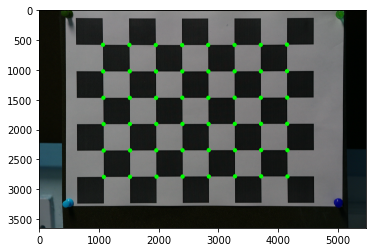

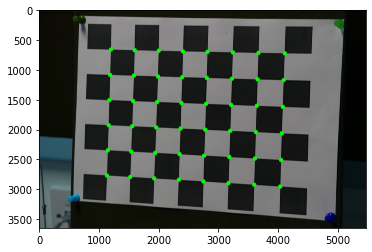

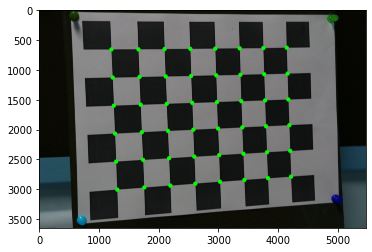

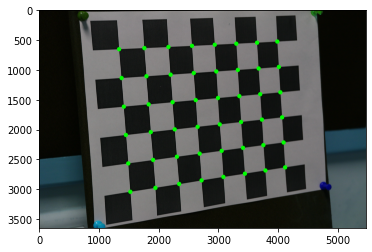

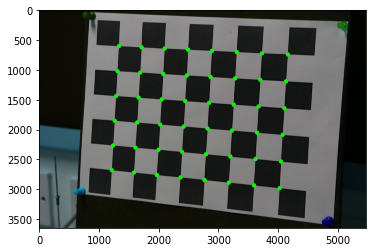

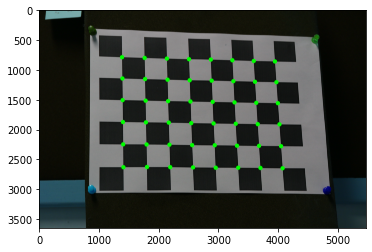

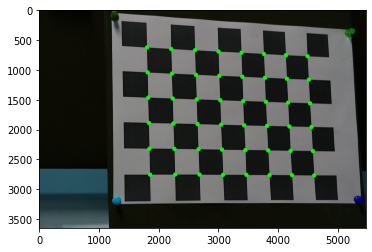

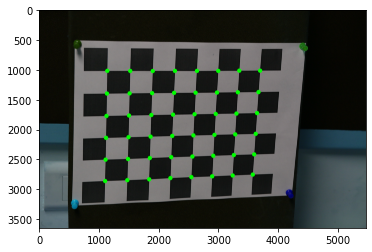

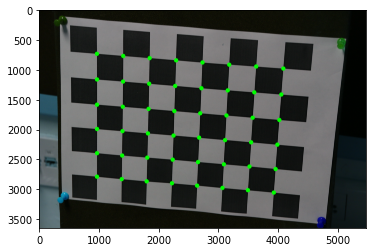

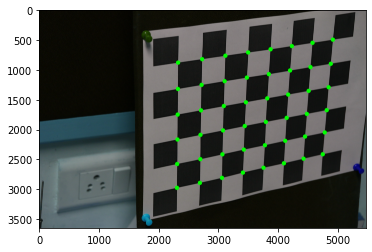

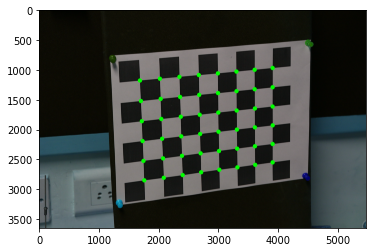

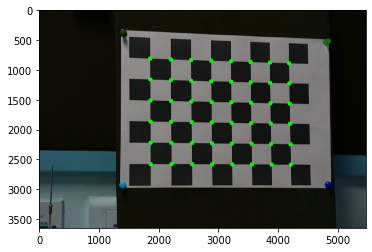

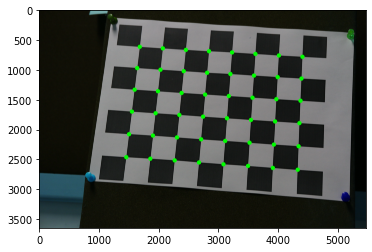

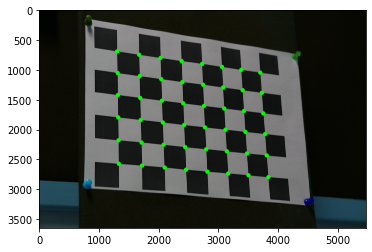

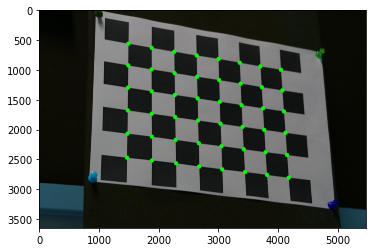

Ret(Error): 2.481084983864163
Mtx(Intrinsic Matrix):
 [[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660119e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------------------------------> [ (3, 3) ]
Distortion:
 [[ 9.52132318e-02  1.01092578e+01 -1.52797797e-02  2.87213437e-02
  -1.60589618e+02]]  ----------> [ (1, 5) ]
All rotation vecs:
 (array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.0090686 ],
       [-0.41619663],
       [-0.03572076]]), array([[ 0.01633962],
       [-0.61839259],
       [-0.07755518]]), array([[0.00456626],
       [0.30778498],
       [0.06543949]]), array([[-0.32566614],
       [-0.22232075],
       [-0.01742858]]), array([[-0.19221712],
       [-0.38502427],
       [-0.00381479]]), array([[ 0.24427921],
       [-0.32262064],
       [ 0.02472159]]), array([[0.31114498],
       [0.0663294 ],
       [0.07053942]]), arr

In [71]:
def zhang_calibration(images, size=(8, 6), val=1):
    """Calibrates the camera using Zhang's method."""
    # Create a list of 3d points
    X_rows, Y_cols = size
    world_points = np.zeros((X_rows*Y_cols,3), np.float32)
    world_points[:,:2] = np.mgrid[0:X_rows,0:Y_cols].T.reshape(-1,2)
    # print(world_points)
    img_list = []
    _3d_points=[]
    _2d_points=[]
    
    for img in images:
        ret, corners = cv2.findChessboardCorners(img, size)
        for corner in corners:
            cv2.circle(img, (int(corner[0, 0]), int(corner[0, 1])), 6, (0, 255, 0), 60)
        img_list.append(img)
        # add points only if checkerboard was correctly detected
        world_points_m = np.array([world_points])
        corners2 = np.array([[corner for [corner] in corners]])
        if ret:
            _2d_points.append(corners2)
            _3d_points.append(world_points_m)
            
    if val==2:
        for img in img_list:
            plt.figure()
            plt.imshow(img)
            plt.show()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (img_list[0].shape[1],img_list[0].shape[0]), None, None)
    return ret, mtx, dist, rvecs, tvecs, _3d_points, _2d_points

ret, mtx, dist, rvecs, tvecs, z_world_points, z_img_points = zhang_calibration(zhang_img_list, val=2)

print("Ret(Error):",ret)
print("Mtx(Intrinsic Matrix):\n",mtx," ----------------------------------> [",mtx.shape,"]")
print("Distortion:\n",dist," ----------> [",dist.shape,"]")
print("All rotation vecs:\n",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]")
print("Translation vecs:\n",tvecs," ------------------------------------------------------")

## Zhang vs DLT comparison

```Error (Zhang) = 2.48```<br>
```Error (DLT) = 3.93```<br>
We observe that Zhang has less rmse (projection error) than DLT, therefore, it is better.

# Problem 6: Create a wireframe using Calibration Matrix (Zhang)

## Code Explanation
* We draw the wireframe using the points predicted by Zhangs algorithm.

## Challenges
* Understanidng which points needed to be connected based on the distance between them.

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

In [73]:
folder = "../data/"
image_names = ["checkerboard-01.JPG", "checkerboard-02.JPG", "checkerboard-03.JPG", "checkerboard-04.JPG", "checkerboard-05.JPG",
                "checkerboard-06.JPG", "checkerboard-07.JPG", "checkerboard-08.JPG", "checkerboard-09.JPG", "checkerboard-10.JPG",
                "checkerboard-11.JPG", "checkerboard-12.JPG", "checkerboard-13.JPG", "checkerboard-14.JPG", "checkerboard-15.JPG"]
zhang_img_list = [cv2.imread(os.path.join(folder, x)) for x in image_names]
zhang_img = zhang_img_list[-1]
# # Create a wireframe using Zhang's calibration method

def predict_points_zhang(rvecs, tvecs, mtx, dist, objpoints):
    """Predicts the 3D points of the checkerboard in the image."""
    return cv2.projectPoints(objpoints, rvecs, tvecs, mtx, dist)
ret, mtx, dist, rvecs, tvecs, z_world_points, z_img_points = zhang_calibration(zhang_img_list)
pred_points = predict_points_zhang(rvecs[-1], tvecs[-1], mtx, dist, z_world_points[-1])[0].reshape(48, 2)

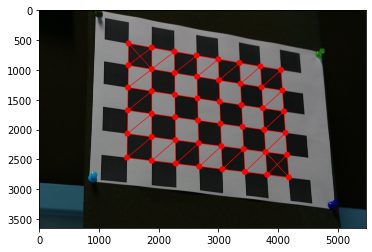

In [74]:
zhang_img = cv2.imread('../data/checkerboard-15.JPG')
pred_points_2 = np.array(pred_points).astype(int)
# print(pred_points_2)
zhang_img = plot_wireframe(zhang_img, pred_points_2)

plt.imshow(zhang_img)
plt.show()

## Observations

In the constructed wireframe, each point coincides with the corresponding corners of squares in the checkerboard, and each overlay wire coincides with the lines/edges of squares in the checkerboard.

# 7: DLT, Ransac on camera images

In [75]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

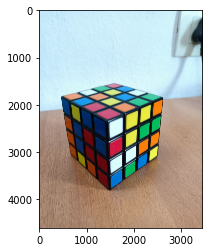

In [76]:
folder = "../images/"
cube_img = plt.imread('../images/cube-03.jpg')
plt.imshow(cube_img)
plt.show()

In [77]:
UNIT = 1

loc_world_coords = np.array([[0, 0, 0],
                        [1, 0, 0],
                        [2, 0, 0],
                        [0, 1, 0],
                        [1, 1, 0],
                        [2, 1, 0],
                        [0, 2, 0],
                        [1, 2, 0],
                        [2, 2, 0],
                        [0, 0, 1],
                        [1, 0, 1],
                        [2, 0, 1],
                        [0, 0, 2],
                        [1, 0, 2],
                        [2, 0, 2],
                        [0, 1, 1],
                        [0, 1, 2],
                        [0, 2, 1],
                        [0, 2, 2]]).astype('float64')

loc_world_coords = loc_world_coords * UNIT

In [78]:
image_points = []

def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        image_points.append([x,y])

read=False
if read==True:
    # reading the image
    img = cv2.imread('../images/cube-03.jpg', 1)

    # plt.figure()
    # plt.imshow(img)
    # plt.show()

    # displaying the image
    w = 720
    h0,w0 = img.shape[0],img.shape[1]
    h = w*img.shape[0]//img.shape[1]
    img = cv2.resize(img, (w,h))
    # img = cv2.resize(img, (100,100))
    cv2.imshow('image', img)

    # setting mouse handler for the image
    # and calling the click_event() function

    while(True):
        cv2.setMouseCallback('image', click_event)
        k = cv2.waitKey(33)
        if cv2.getWindowProperty('image', cv2.WND_PROP_VISIBLE)<1:
        # cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()
    image_points = np.array(image_points).astype('float64')
    image_points[:,0] = image_points[:,0]*h0/h
    image_points[:,1] = image_points[:,1]*w0/w

else:
    image_points = np.array([[1440.,  2361.6],
                            [1804.8, 2217.6],
                            [2126.4, 2092.8],
                            [1464. , 2774.4],
                            [1795.2, 2611.2],
                            [2097.6, 2472. ],
                            [1483.2, 3168. ],
                            [1795.2, 2971.2],
                            [2083.2, 2808. ],
                            [1147.2, 2198.4],
                            [1488. , 2064. ],
                            [1814.4, 1948.8],
                            [ 892.8, 2064. ],
                            [1233.6, 1944. ],
                            [1540.8, 1843.2],
                            [1166.4, 2616. ],
                            [ 907.2, 2443.2],
                            [1190.4, 2961.6],
                            [ 950.4, 2793.6]]).astype('float64')
    

[[1440.  2361.6]
 [1804.8 2217.6]
 [2126.4 2092.8]
 [1464.  2774.4]
 [1795.2 2611.2]
 [2097.6 2472. ]
 [1483.2 3168. ]
 [1795.2 2971.2]
 [2083.2 2808. ]
 [1147.2 2198.4]
 [1488.  2064. ]
 [1814.4 1948.8]
 [ 892.8 2064. ]
 [1233.6 1944. ]
 [1540.8 1843.2]
 [1166.4 2616. ]
 [ 907.2 2443.2]
 [1190.4 2961.6]
 [ 950.4 2793.6]]


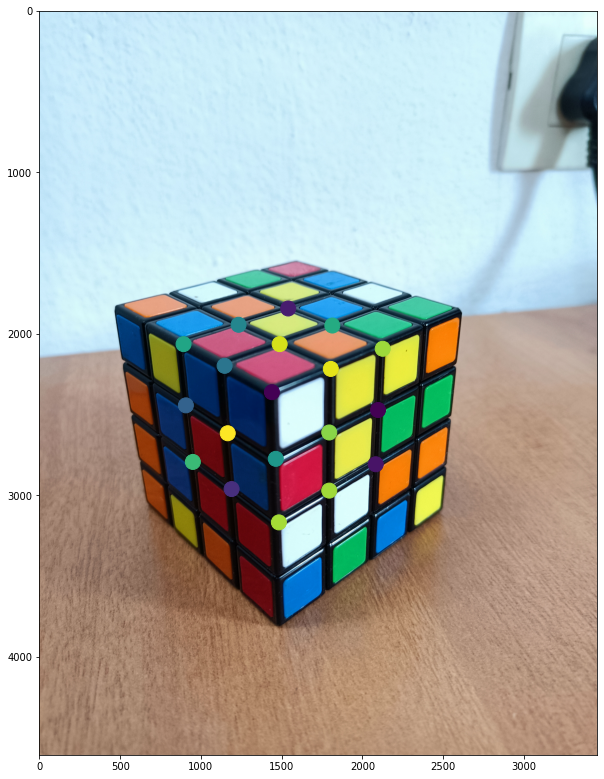

In [79]:
N = len(image_points)
fig = plt.figure(figsize=(10,15))

img=plt.imread('../images/cube-03.jpg')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

print(image_points)
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [80]:
x,X = homo_coords(image_points, loc_world_coords)

P,M,K,R,t = DLT(x,X)
print('P is :\n',P)
print('M is :\n',M)
print('K is :\n',K)
print('R is :\n',R)
print('t is :\n',t)

err = get_err(x,X,P)
print("rmse ",err)

P is :
 [[ 4.82488567e+02  8.75332167e+01 -2.22952978e+02  1.44759689e+03]
 [ 3.59798165e+00  5.60396602e+02 -1.06790604e+01  2.36530821e+03]
 [ 6.94403497e-02  5.15184606e-02  6.87649021e-02  1.00000000e+00]]
M is :
 [[-0.0000e+00 -0.0000e+00 -0.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.4400e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -0.0000e+00 -0.0000e+00
  -0.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  2.3616e+03]
 [-1.0000e+00 -0.0000e+00 -0.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  1.8048e+03  0.0000e+00  0.0000e+00  1.8048e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -1.0000e+00 -0.0000e+00
  -0.0000e+00 -1.0000e+00  2.2176e+03  0.0000e+00  0.0000e+00  2.2176e+03]
 [-2.0000e+00 -0.0000e+00 -0.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  4.2528e+03  0.0000e+00  0.0000e+00  2.1264e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00

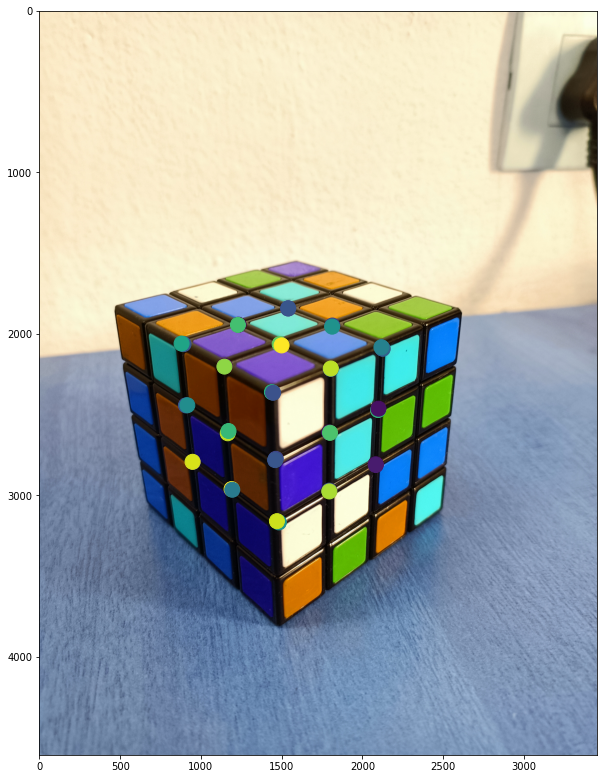

In [81]:
reproject(P,X,x,path='../images/cube-03.jpg')

# 8. Image of the world origin

Image of the world origin can be given by p4 (4th column in the P matrix). The image coordinates of the center are given by ```(P[3,0]/P[3,2] , P[3,0]/P[3,2])```. However, P[3,2] is already 1, so we can directly use ```(P[3,0], P[3,1])``` as the ```(x,y)``` coordinates fo the image of world origin.

### This result also bears with our observation

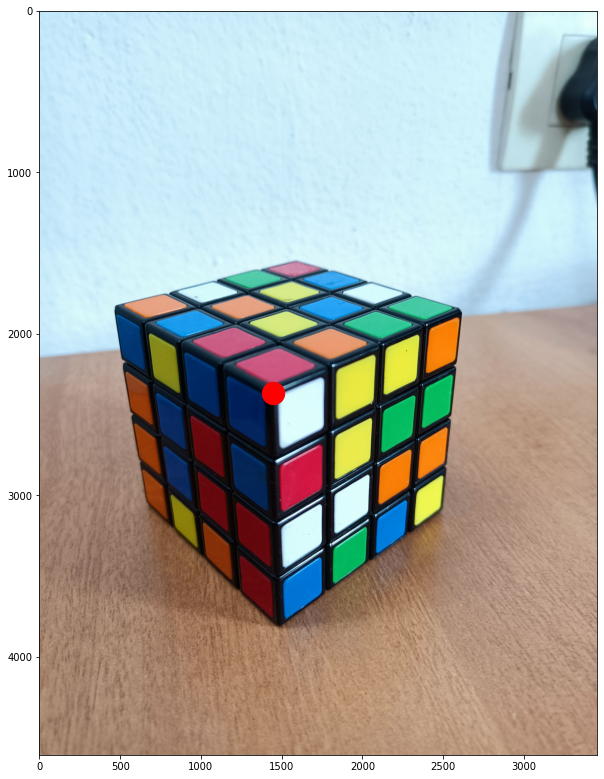

In [95]:
plt.figure(figsize=(10,15))
img = plt.imread('../images/cube-03.jpg')
plt.imshow(img)
plt.scatter(P[0,3], P[1,3], c='red', s=500)
plt.show()

In [82]:
best_values = ransac_estimation(image_points, loc_world_coords)
for key, value in best_values.items():
    print(f"{key} : {value}")

P : [[ 4.84518053e+02  8.77711302e+01 -2.24606111e+02  1.44803350e+03]
 [ 4.89128833e+00  5.59972851e+02 -1.73490573e+01  2.36533434e+03]
 [ 7.09903949e-02  5.17018937e-02  6.60298793e-02  1.00000000e+00]]
M : [[-2.0000e+00 -0.0000e+00 -1.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  3.6288e+03  0.0000e+00  1.8144e+03  1.8144e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -2.0000e+00 -0.0000e+00
  -1.0000e+00 -1.0000e+00  3.8976e+03  0.0000e+00  1.9488e+03  1.9488e+03]
 [-1.0000e+00 -2.0000e+00 -0.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  1.7952e+03  3.5904e+03  0.0000e+00  1.7952e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -1.0000e+00 -2.0000e+00
  -0.0000e+00 -1.0000e+00  2.9712e+03  5.9424e+03  0.0000e+00  2.9712e+03]
 [-0.0000e+00 -0.0000e+00 -1.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.1472e+03  1.1472e+03]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000

/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: divide by zero encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: invalid value encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/1845656440.py:2: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T


/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: divide by zero encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/378639587.py:23: RuntimeWarning: invalid value encountered in true_divide
  P /= P[-1,-1]
/tmp/ipykernel_8698/1845656440.py:2: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T
/tmp/ipykernel_8698/1845656440.py:5: RuntimeWarning: divide by zero encountered in true_divide
  points = points / points[2]
/tmp/ipykernel_8698/1845656440.py:5: RuntimeWarning: invalid value encountered in true_divide
  points = points / points[2]
/tmp/ipykernel_8698/1561311264.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Nu

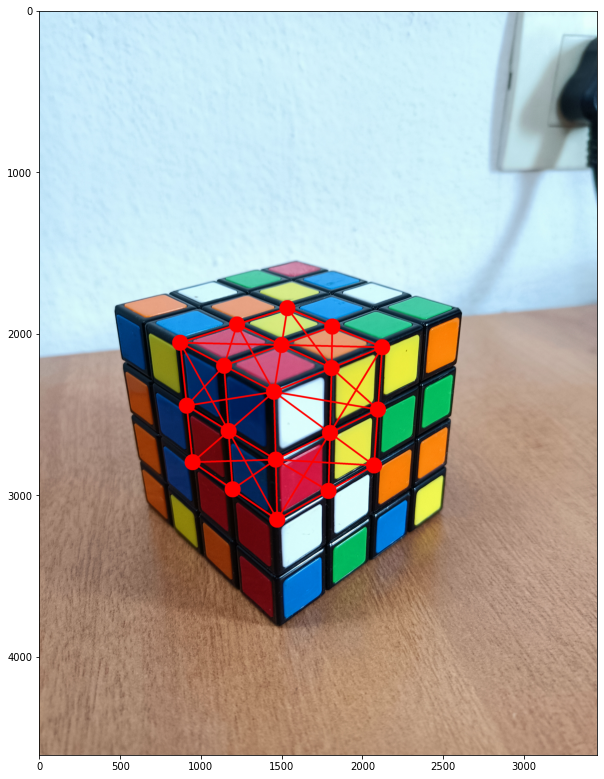

In [83]:
plt.figure(figsize=(10,15))
image = plt.imread('../images/cube-03.jpg')

best_values = ransac_estimation(image_points, loc_world_coords)
projection_matrix = best_values['P']
pred_points = predict_points(projection_matrix, loc_world_coords)
img = plot_wireframe(image, pred_points[0:9])
# plt.imshow(img)
img = plot_wireframe(img, pred_points[np.r_[0:3, 9:15]])
img = plot_wireframe(img, pred_points[np.r_[0:1, 3:4, 6:7, 9:10, 12:13, 15:19]])
plt.imshow(img)
plt.show()

# 9. Zhang on camera images

In [84]:
folder = "../images/"
image_names = ["chessboard-01.jpg", "chessboard-02.jpg", "chessboard-03.jpg", "chessboard-04.jpg", "chessboard-05.jpg"]
zhang_img_list = [cv2.imread(os.path.join(folder, x)) for x in image_names]

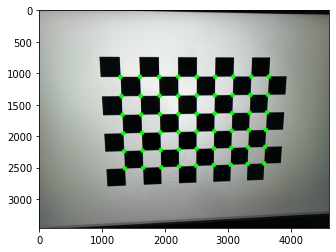

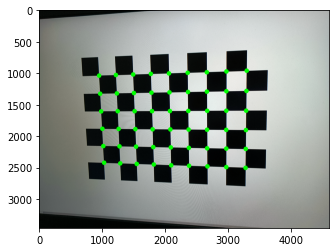

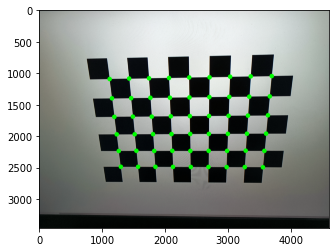

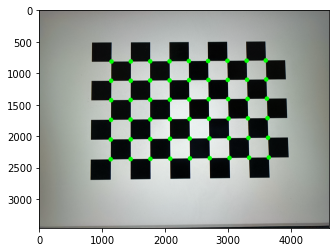

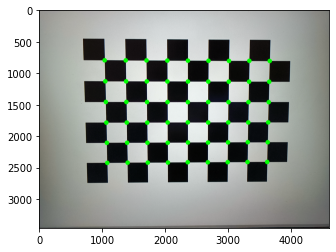

Ret(Error): 1.3558112240361953
Mtx(Intrinsic Matrix):
 [[3.68855012e+03 0.00000000e+00 2.31034984e+03]
 [0.00000000e+00 3.68597783e+03 1.73832933e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------------------------------> [ (3, 3) ]
Distortion:
 [[-2.77897635e-02  2.26194098e-01 -3.07581827e-04 -3.38947506e-04
  -4.69808183e-01]]  ----------> [ (1, 5) ]
All rotation vecs:
 (array([[ 0.16565265],
       [-0.08637264],
       [-0.01184472]]), array([[ 0.11131979],
       [ 0.16741121],
       [-0.00807521]]), array([[ 0.32788877],
       [ 0.05020631],
       [-0.01635273]]), array([[-0.05598788],
       [-0.00971619],
       [-0.01049597]]), array([[ 0.07008112],
       [-0.02203561],
       [-0.00078922]]))  --------------------------------------------------------> [ (3, 1) ]
Translation vecs:
 (array([[-3.32182068],
       [-2.22142518],
       [12.07073718]]), array([[-4.76077761],
       [-2.45622936],
       [12.96748895]]), array([[-3.75887092],
       [-2.04255176]

In [85]:
ret, mtx, dist, rvecs, tvecs, z_world_points, z_img_points = zhang_calibration(zhang_img_list, size=(9,6), val=2)

print("Ret(Error):",ret)
print("Mtx(Intrinsic Matrix):\n",mtx," ----------------------------------> [",mtx.shape,"]")
print("Distortion:\n",dist," ----------> [",dist.shape,"]")
print("All rotation vecs:\n",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]")
print("Translation vecs:\n",tvecs," ------------------------------------------------------")

## Observations
* ```Error (DLT) = 5.06```
```Error (Ransac) = 5.49```
```Error (Zhang) = 1.36```

    We observe that Zhang has the least error values out of the 3 calibration methods used.

* Also, DLT and RANSAC give almost similar calibration matrices K, which is expected, as K is an intrinsic parameter of the camera.